Kaggle Competition: Early detection of 3D printing issues

The goal of the project is to build a model to detect a common error in 3D printing - under extrusion - at an early stage.

Wing Man Casca, Kwok
Apr 11 2023

In [ ]:
%cd "/content/drive/MyDrive/Colab Notebooks/3D_Printing"

'''
# Download dataset
!pip install kaggle

import os
os.environ["KAGGLE_CONFIG_DIR"] = "/content/drive/MyDrive/Colab Notebooks/"
!kaggle competitions download -c early-detection-of-3d-printing-issues
!unzip *.zip
'''

In [ ]:
# import libraries
!pip install transformers
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import models, datasets, transforms
from sklearn.model_selection import train_test_split
from PIL import Image                                       
from torch.utils.data import Dataset, DataLoader
import cv2
import torchvision.transforms as T
from PIL import Image
from torchvision import transforms
from transformers import get_linear_schedule_with_warmup
from sklearn import model_selection    

import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, average_precision_score, average_precision_score

In [ ]:
# Model configuration Settings
BATCH_SIZE = 128
LR = 0.01
EPOCHS = 10
log_interval = 10
MOMENTUM = 0.5

In [ ]:
# check GPU resources
def check_processor():
    
    if torch.cuda.is_available():
        device = 'cuda'
        print('Using cuda\n')
    else:
        device = 'cpu'
        print('Using cpu\n')
        
    return device

In [ ]:
# EDA
def EDA(df, images):
    
    print("EDA:", "\n")
          
    print("Training Dataset size:", len(df), "\n")
    print("Label Distribution:\n")
    print(df['has_under_extrusion'].value_counts(), "\n")
    
    print("Image size (channel, height, width):", images[0].shape, images[1].shape, "\n")

In [ ]:
# display dataset for EDA
def plot(images, labels, path):
    
    plt.subplots(figsize=(15, 15))
    
    for i in range(15):
        plt.subplot(5, 5, i+1)
        plt.tight_layout()
        plt.axis("off"); plt.xticks([]) ; plt.yticks([]) 
        plt.title("Ground Truth: {}".format(labels[i]))
        
        images_rgb = images[i].squeeze()
        images_rgb = (np.transpose(images_rgb, (0, 2, 1)).T).detach().numpy()
        plt.imshow(cv2.cvtColor(images_rgb, cv2.COLOR_BGR2RGB))
        
        print(path[i])
        
    plt.show()

In [ ]:
# Dataset class to loan training and validation dataset
class DDDPrintingDataset(Dataset):
    
    def __init__(self, df, image_folder, is_train=True):
        self.df = df
        self.image_folder = image_folder
        self.transforms_list = [transforms.RandomHorizontalFlip(p=0.5),
                                 transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
                                 transforms.RandomGrayscale(p=0.2),
                                 transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))]
                                 
        self.transform_train = transforms.Compose([transforms.ToTensor(), 
                                                   transforms.Resize((224, 224), antialias=False),
                                                   transforms.RandomApply(self.transforms_list, p=0.5)
                                                   #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                                   ])
        self.transform_val1 = transforms.Compose([transforms.ToTensor(), transforms.Resize((224,224), antialias=False)])
        self.transform_val2 = transforms.Compose([self.transform_val1, transforms.RandomApply(self.transforms_list, p=0.5)])
       
        self.is_train = is_train

        print("self.is_train", self.is_train)
        
    def __len__(self):
        return len(self.df)
        
    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.df.iloc[idx, 0])
        label = self.df.iloc[idx, 3]

        try:
          image = Image.open(img_name)
          if self.is_train:
            image = self.transform_train(image)
            return image, label, img_name
          else:
            val_transform1 = self.transform_val1(image)
            val_transform2 = self.transform_val2(image)
            val_transform3 = self.transform_val2(image)
            val_transform4 = self.transform_val2(image)
            return val_transform1, label, img_name, val_transform2, val_transform3, val_transform4

        except FileNotFoundError as e:
          print(f"Caught TypeError for file {img_name}: {str(e)}")

In [ ]:
# Dataset class to loan testing dataset
class DDDPrintingTestingDataset(Dataset):
    
    def __init__(self, df, image_folder, is_train=False):
        self.df = df
        self.image_folder = image_folder
        self.transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((224, 224), antialias=False),
                                             #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                             ])
        self.is_train = is_train
        
    def __len__(self):
        return len(self.df)
        
    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.df.iloc[idx, 0])

        try:
          image = Image.open(img_name)
          image = self.transform(image)
          
        except FileNotFoundError as e:
          print(f"Caught TypeError for file {img_name}: {str(e)}")

        return image, img_name

In [ ]:
# training
def train(n_epochs, model, train_loader, optimizer, log_interval, device):
       
    start_time = time.time()
  
    train_losses = []
    train_counter = []
    pred_list = []
    labels_list = []
    criterion = nn.CrossEntropyLoss()
            
    for batch_idx, (images, labels, _) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()      

        output = model(images)
        loss = criterion(output, labels)

        pred = output.data.max(1, keepdim=True)[1] 
        pred_list.append(pred.cpu().squeeze().tolist())    # compute f1 score
        labels_list.append(labels.cpu().squeeze().tolist()) # compute f1 score

        if batch_idx % log_interval == 0 and batch_idx != 0:
            f1score = f1_score(pred_list, labels_list, average='macro')
            print("F1 score\n", f1score)
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(n_epochs, batch_idx * len(labels), len(train_loader.dataset), 100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append((batch_idx*64) + ((n_epochs-1)*len(train_loader.dataset)))
            pred_list = []; labels_list = []
            
            if loss.item() < best_loss:
              best_loss = loss.item()
              print("best_loss", best_loss)
              torch.save(model.state_dict(), './model.pth') 
              torch.save(optimizer.state_dict(), './optimizer.pth')
              #torch.save(scheduler.state_dict(), './scheduler.pth') 

        loss.backward()
        optimizer.step()
        scheduler.step()
            
    total_time = time.time() - start_time
    print("Total running time:", total_time)
    
    return train_losses, train_counter

In [ ]:
# validation
def validate(model, val_loader, device):

    model.to(device)
    model.eval()
    
    test_loss = 0
    correct = 0
    pred_list = []
    test_losses = []
    paths = []
    labels_list = []
    
    criterion = nn.CrossEntropyLoss()
    
    with torch.no_grad():                    
        for index, (image, label, path, val_transform2, val_transform3, val_transform4) in enumerate(val_loader):
            image, label = image.to(device), label.to(device)
            val_transform2, val_transform3, val_transform4 = val_transform2.to(device), val_transform3.to(device), val_transform4.to(device) 
            
            """
            # ensemble 4 transforms and take the average probability
            output1 = model(image)
            output2 = model(val_transform2)
            output3 = model(val_transform3)
            output4 = model(val_transform4)
            output = (output1 + output2 + output3 + output4)/4
            """
            output1 = model(image)
            output2 = model(torch.fliplr(image))
            output = (output1 + output2) / 2
            #output = torch.max(output1, output2)

            test_loss += criterion(output, label)

            # computes the maximum value along the second dimension of the output
            # which corresponds to the predicted class scores
            # pred is a tensor containing the predicted class label
            pred = output.data.max(1, keepdim=True)[1]

            # label.data.view_as(pred) reshapes the ground truth label tensor to have the same dimensions as the predicted label tensor. 
            # predicted label tensor has shape (batch_size, 1)
            # label tensor has shape (batch_size,)
            correct += pred.eq(label.data.view_as(pred)).sum() # compute precision
            pred_list.append(pred.cpu().squeeze().tolist())    # compute f1 score
            labels_list.append(label.cpu().squeeze().tolist()) # compute f1 score
            paths.append(path)

            if index % 10 == 0 and index != 0:
              print('Validation index: {} [{}/{} ({:.0f}%)]\tAverage Loss: {:.6f}'.format(index, index, len(val_loader), 100. * index / len(val_loader), test_loss/index))
              print("F1 score\n", f1_score(pred_list, labels_list, average='macro'))      

    test_loss /= len(val_loader.dataset)
    test_losses.append(test_loss)
    accuracy = 100. * correct / len(val_loader.dataset)
    
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, len(val_loader.dataset), 100. * correct / len(val_loader.dataset)))

In [ ]:
# test
def test(model, test_loader, device):

    #load the internal state of the network and optimizer when we last saved them.
    model_saved = torch.load('/content/drive/MyDrive/Colab Notebooks/3D_Printing/train_weight/train_weight-0414 224x224 transform seq clear 10 epochs full dataset scheduler/model.pth')
    model.load_state_dict(model_saved)

    model.to(device)
    model.eval()
    
    pred_list = []
    paths_list = []
    df_test_result = pd.DataFrame({'img_path': paths_list, 'has_under_extrusion': pred_list})

    with torch.no_grad():                    
         for index, (image, image_path) in enumerate(test_loader):
            image = image.to(device)
            
            # ensemble output with image and a flipped left right image
            output1 = model(image)
            output2 = model(torch.fliplr(image))
            output = (output1 + output2) / 2
            #output = max(output1, output2)
            
            # computes the maximum value along the second dimension of the output
            # which corresponds to the predicted class scores
            # pred is a tensor containing the predicted class label
            pred = output.data.max(1, keepdim=True)[1]

            pred_list.append(pred.flatten().tolist())
            paths_list.append(image_path)

            for item1, item2 in zip(image_path, pred.flatten().tolist()):
                df_test_result.loc[len(df_test_result)] = [item1, item2]
          
            if index % 10 == 0 and index !=0:
              print('Testing index: {} [{}/{} ({:.0f}%)]'.format(index, index, len(test_loader), 100. * index / len(test_loader)))
              df_test_result.to_csv('test_result.csv')

    df_test_result.to_csv('test_result.csv')           
    return pred_list, paths_list

self.is_train True
self.is_train False
tensor([0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0,
        1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0,
        0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0,
        1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1,
        0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1,
        1, 1, 0, 0, 1, 1, 1, 0])
Images of first training batch:


<ipython-input-6-baf154284c94>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(5, 5, i+1)
<ipython-input-6-baf154284c94>:12: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3571.)
  images_rgb = (np.transpose(images_rgb, (0, 2, 1)).T).detach().numpy()


/content/drive/MyDrive/Colab Notebooks/3D_Printing/images/102/1678739903/1678741346.006689.jpg
/content/drive/MyDrive/Colab Notebooks/3D_Printing/images/102/1678816535/1678817763.53425.jpg
/content/drive/MyDrive/Colab Notebooks/3D_Printing/images/104/1678415191/1678415380.78373.jpg
/content/drive/MyDrive/Colab Notebooks/3D_Printing/images/104/1678445757/1678446582.570143.jpg
/content/drive/MyDrive/Colab Notebooks/3D_Printing/images/104/1678450861/1678451109.812096.jpg
/content/drive/MyDrive/Colab Notebooks/3D_Printing/images/101/1678341667/1678342207.929772.jpg
/content/drive/MyDrive/Colab Notebooks/3D_Printing/images/104/1678454755/1678455417.900603.jpg
/content/drive/MyDrive/Colab Notebooks/3D_Printing/images/102/1678766920/1678768483.71971.jpg
/content/drive/MyDrive/Colab Notebooks/3D_Printing/images/104/1678414274/1678415119.584807.jpg
/content/drive/MyDrive/Colab Notebooks/3D_Printing/images/101/1678344738/1678345309.896584.jpg
/content/drive/MyDrive/Colab Notebooks/3D_Printing/im

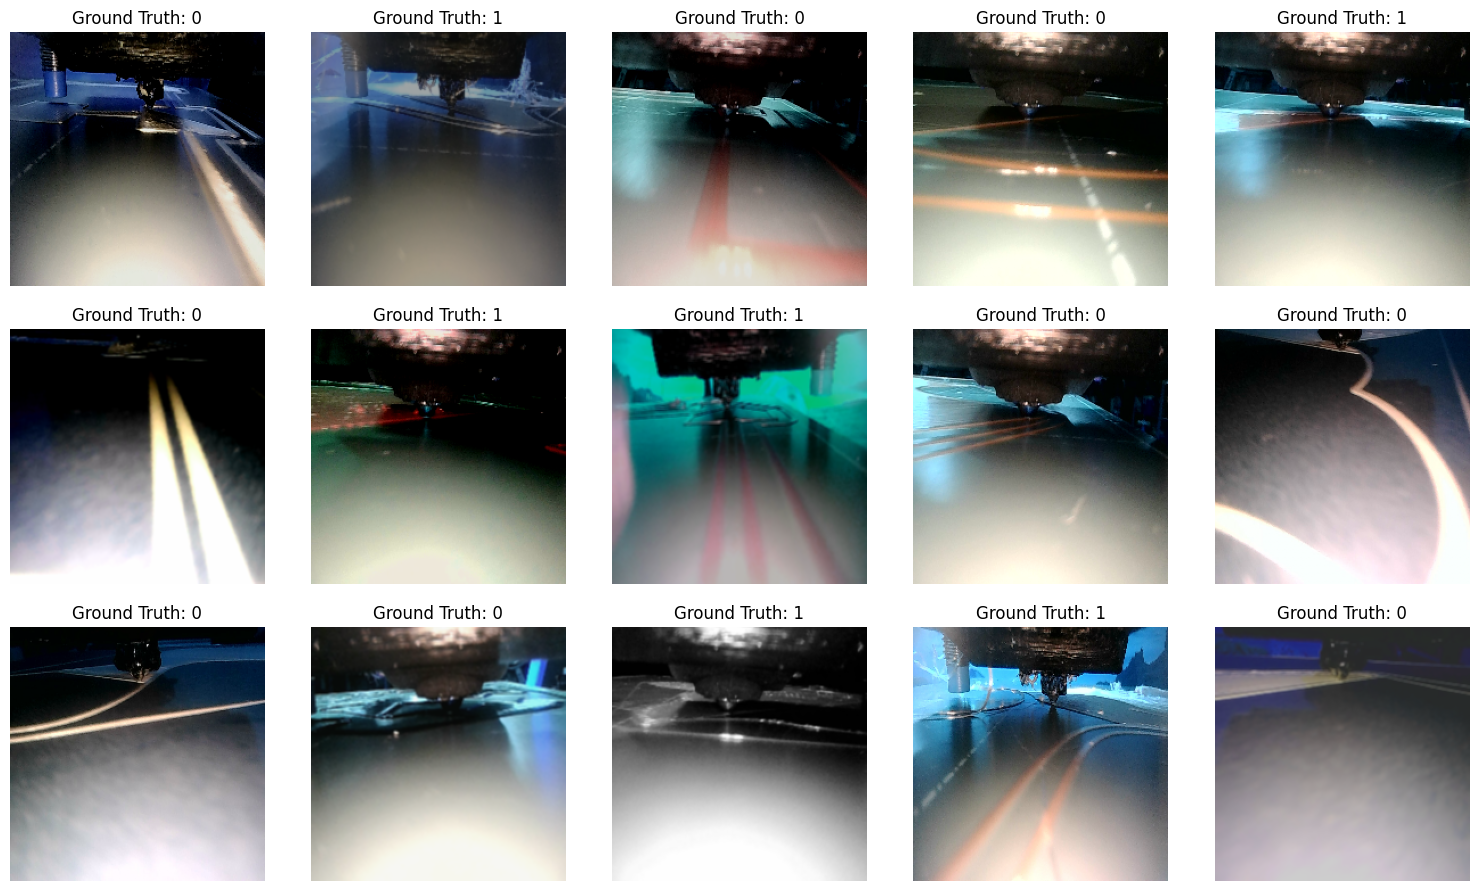

EDA: 

Training Dataset size: 77007 

Label Distribution:

1    42165
0    34842
Name: has_under_extrusion, dtype: int64 

Image size (channel, height, width): torch.Size([3, 224, 224]) torch.Size([3, 224, 224]) 



In [ ]:
# main code
image_folder = "/content/drive/MyDrive/Colab Notebooks/3D_Printing/images/"
train_label_csv_folder = "/content/drive/MyDrive/Colab Notebooks/3D_Printing/train.csv"
test_label_csv_folder = "/content/drive/MyDrive/Colab Notebooks/3D_Printing/test.csv"

df = pd.read_csv(train_label_csv_folder)

# split training and validation dataset
train_df, val_df = train_test_split(df, test_size=0.05, shuffle=True)
test_df = pd.read_csv(test_label_csv_folder)

# Set training and validation dataset
train_dataset = DDDPrintingDataset(train_df, image_folder)
val_dataset = DDDPrintingDataset(val_df, image_folder, is_train=False)
test_dataset = DDDPrintingTestingDataset(test_df, image_folder)

# Get dataloader
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=8)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=8)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=8)

# Check Dataset is working
images, labels, path = next(iter(train_dataloader))
print(labels)
print("Images of first training batch:")
plot(images, labels.tolist(), path)

EDA(train_df, images)

In [ ]:
# choose CNN models
device = check_processor()

model = models.resnet34(pretrained=True)
model.fc =  nn.Sequential(nn.Dropout(0.1),nn.Linear(512, 2)) # use print(model) command to check last layer output
#model = models.resnet101(pretrained=True)
#model.fc =  nn.Sequential(nn.Dropout(0.1),nn.Linear(2048, 2))
#model_vgg = models.vgg11(pretrained=True)
#model_vgg.classifier[3] = torch.nn.Linear(in_features=model_vgg.classifier[3].in_features, out_features=512)
#model_vgg.classifier[6] = torch.nn.Linear(in_features=4096, out_features=2)

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5, weight_decay=0.0001) 

In [ ]:
# freeze layers resnet32
def freeze_layers(model): 
  for name, param in model.named_parameters():  
    if "fc.1" in name or "layer4.2" in name:
    #if "fc.1" in name:
        param.requires_grad = True
        print(name, param.requires_grad)
    else:
        param.requires_grad = False

In [ ]:
# freeze layers VGG
'''
def freeze_layers(model): 
  for name, param in model.named_parameters(): 
    if "classifier" in name or "features.49" in name or "features.50" in name:
        param.requires_grad = True
        print(name, param.requires_grad)
    else:
        param.requires_grad = False
'''

In [ ]:
# training
start_time = time.time()

# freezing shallow layer weight
#freeze_layers(model)

model_saved = torch.load('/content/drive/MyDrive/Colab Notebooks/3D_Printing/train_weight/train_weight0416_cleared loan weight every epoch/model.pth', map_location=device)
model.load_state_dict(model_saved)
optimizer_saved = torch.load('/content/drive/MyDrive/Colab Notebooks/3D_Printing/train_weight/train_weight0416_cleared loan weight every epoch/optimizer.pth', map_location=device)
optimizer.load_state_dict(optimizer_saved)

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=-1)
best_loss = 100

model.to(device)
model.train()

for epoch in range(1, EPOCHS + 1): 
    print("Training")
    best_loss = train(epoch, model, train_dataloader, optimizer, log_interval, device)
    validate(model, val_dataloader, device)

total_time = time.time() - start_time

layer4.2.conv1.weight True
layer4.2.bn1.weight True
layer4.2.bn1.bias True
layer4.2.conv2.weight True
layer4.2.bn2.weight True
layer4.2.bn2.bias True
fc.1.weight True
fc.1.bias True
Training
F1 score
 0.9970328282828282
Train Epoch: 1 [1280/77007 (2%)]	Loss: 0.016036
best_loss 0.016035854816436768
F1 score
 0.997046182983683
Train Epoch: 1 [2560/77007 (3%)]	Loss: 0.008856
best_loss 0.008855778723955154
F1 score
 0.9951983065953655
Train Epoch: 1 [3840/77007 (5%)]	Loss: 0.011337
F1 score
 0.9953744172494172
Train Epoch: 1 [5120/77007 (7%)]	Loss: 0.003028
best_loss 0.003027717350050807
F1 score
 0.9948783855033855
Train Epoch: 1 [6400/77007 (8%)]	Loss: 0.004773
F1 score
 0.99458648989899
Train Epoch: 1 [7680/77007 (10%)]	Loss: 0.035726
F1 score
 0.9941105769230769
Train Epoch: 1 [8960/77007 (12%)]	Loss: 0.002353
best_loss 0.002353021875023842
F1 score
 0.9969527000777001
Train Epoch: 1 [10240/77007 (13%)]	Loss: 0.006447
F1 score
 0.9970753205128206
Train Epoch: 1 [11520/77007 (15%)]	Loss

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


F1 score
 0.9894072940947941
Train Epoch: 1 [15360/77007 (20%)]	Loss: 0.004493


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


F1 score
 0.9888921842046843
Train Epoch: 1 [16640/77007 (22%)]	Loss: 0.001392
best_loss 0.001392482197843492
F1 score
 0.9942708333333333
Train Epoch: 1 [17920/77007 (23%)]	Loss: 0.008549
F1 score
 0.9963416791541791
Train Epoch: 1 [19200/77007 (25%)]	Loss: 0.013368
F1 score
 0.9992897727272727
Train Epoch: 1 [20480/77007 (27%)]	Loss: 0.002921
F1 score
 0.9961465617715618
Train Epoch: 1 [21760/77007 (28%)]	Loss: 0.006995
F1 score
 0.9961522852147852
Train Epoch: 1 [23040/77007 (30%)]	Loss: 0.002762
F1 score
 0.9968434343434344
Train Epoch: 1 [24320/77007 (32%)]	Loss: 0.014115
F1 score
 0.9946799728049728
Train Epoch: 1 [25600/77007 (33%)]	Loss: 0.003154
F1 score
 0.9974149114774116
Train Epoch: 1 [26880/77007 (35%)]	Loss: 0.008789
F1 score
 0.9940609737484738
Train Epoch: 1 [28160/77007 (37%)]	Loss: 0.002591
F1 score
 0.9978234082094377
Train Epoch: 1 [29440/77007 (38%)]	Loss: 0.002916
F1 score
 0.9953264260249555
Train Epoch: 1 [30720/77007 (40%)]	Loss: 0.042502
F1 score
 0.995091540

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


F1 score
 0.9745310245310246
Train Epoch: 1 [34560/77007 (45%)]	Loss: 0.017871
F1 score
 0.9973056457431457
Train Epoch: 1 [35840/77007 (47%)]	Loss: 0.003759
F1 score
 0.9972999222999223
Train Epoch: 1 [37120/77007 (48%)]	Loss: 0.005629
F1 score
 0.9949503621378621
Train Epoch: 1 [38400/77007 (50%)]	Loss: 0.013305
F1 score
 0.9945998445998446
Train Epoch: 1 [39680/77007 (51%)]	Loss: 0.006509
F1 score
 0.9980878496503496
Train Epoch: 1 [40960/77007 (53%)]	Loss: 0.005208
F1 score
 0.9936440295815296
Train Epoch: 1 [42240/77007 (55%)]	Loss: 0.002154
F1 score
 0.99771148989899
Train Epoch: 1 [43520/77007 (56%)]	Loss: 0.003124
F1 score
 0.998672385620915
Train Epoch: 1 [44800/77007 (58%)]	Loss: 0.018715
F1 score
 0.9961838508713509
Train Epoch: 1 [46080/77007 (60%)]	Loss: 0.001295
best_loss 0.0012952066026628017
F1 score
 0.9934173465423466
Train Epoch: 1 [47360/77007 (61%)]	Loss: 0.003371
F1 score
 0.9965095668220669
Train Epoch: 1 [48640/77007 (63%)]	Loss: 0.030092
F1 score
 0.99868881118

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


F1 score
 0.9907986111111111
Train Epoch: 1 [57600/77007 (75%)]	Loss: 0.007241
F1 score
 0.997142094017094
Train Epoch: 1 [58880/77007 (76%)]	Loss: 0.005025
F1 score
 0.9967475233100234
Train Epoch: 1 [60160/77007 (78%)]	Loss: 0.002707
F1 score
 0.9968998015873016
Train Epoch: 1 [61440/77007 (80%)]	Loss: 0.011127
F1 score
 0.9937375124875125
Train Epoch: 1 [62720/77007 (81%)]	Loss: 0.025127
F1 score
 0.9966989607614607
Train Epoch: 1 [64000/77007 (83%)]	Loss: 0.007052
F1 score
 0.9985795454545454
Train Epoch: 1 [65280/77007 (85%)]	Loss: 0.001443


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


F1 score
 0.9877670940170941
Train Epoch: 1 [66560/77007 (86%)]	Loss: 0.001976
F1 score
 0.9961459190319485
Train Epoch: 1 [67840/77007 (88%)]	Loss: 0.003374
F1 score
 0.9970012626262627
Train Epoch: 1 [69120/77007 (90%)]	Loss: 0.012969
F1 score
 0.9984217171717171
Train Epoch: 1 [70400/77007 (91%)]	Loss: 0.006495
F1 score
 0.9967848124098124
Train Epoch: 1 [71680/77007 (93%)]	Loss: 0.005424
F1 score
 0.9966856060606061
Train Epoch: 1 [72960/77007 (95%)]	Loss: 0.010954
F1 score
 0.9972683566433567
Train Epoch: 1 [74240/77007 (96%)]	Loss: 0.008146
F1 score
 0.9988782051282051
Train Epoch: 1 [75520/77007 (98%)]	Loss: 0.001233
best_loss 0.0012331199832260609
F1 score
 0.9977621336996337
Train Epoch: 1 [76800/77007 (100%)]	Loss: 0.016966
Total running time: 5283.419335365295
Training
F1 score
 0.9986111111111111
Train Epoch: 2 [1280/77007 (2%)]	Loss: 0.009980
best_loss 0.009979655966162682
F1 score
 0.9971263111888112
Train Epoch: 2 [2560/77007 (3%)]	Loss: 0.011749
F1 score
 0.994631981580

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


F1 score
 0.9873329795204795
Train Epoch: 2 [15360/77007 (20%)]	Loss: 0.019663


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


F1 score
 0.9860533563658563
Train Epoch: 2 [16640/77007 (22%)]	Loss: 0.019980
F1 score
 0.9973056457431457
Train Epoch: 2 [17920/77007 (23%)]	Loss: 0.005985
F1 score
 0.998015873015873
Train Epoch: 2 [19200/77007 (25%)]	Loss: 0.002403
best_loss 0.0024034904781728983
F1 score
 0.9993990384615384
Train Epoch: 2 [20480/77007 (27%)]	Loss: 0.005853
F1 score
 0.9953934953934954
Train Epoch: 2 [21760/77007 (28%)]	Loss: 0.031513
F1 score
 0.9958479020979021
Train Epoch: 2 [23040/77007 (30%)]	Loss: 0.002754
F1 score
 0.9971105283605284
Train Epoch: 2 [24320/77007 (32%)]	Loss: 0.002501
F1 score
 0.9959268162393162
Train Epoch: 2 [25600/77007 (33%)]	Loss: 0.005561
F1 score
 0.9943632756132756
Train Epoch: 2 [26880/77007 (35%)]	Loss: 0.009202
F1 score
 0.9923861371471666
Train Epoch: 2 [28160/77007 (37%)]	Loss: 0.000845
best_loss 0.000844809808768332
F1 score
 0.9992897727272727
Train Epoch: 2 [29440/77007 (38%)]	Loss: 0.003832
F1 score
 0.9958472593582888
Train Epoch: 2 [30720/77007 (40%)]	Loss:

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


F1 score
 0.9804010225885227
Train Epoch: 2 [34560/77007 (45%)]	Loss: 0.031288
F1 score
 0.9991319444444444
Train Epoch: 2 [35840/77007 (47%)]	Loss: 0.002037
F1 score
 0.9979008838383838
Train Epoch: 2 [37120/77007 (48%)]	Loss: 0.002806
F1 score
 0.9981679778554778
Train Epoch: 2 [38400/77007 (50%)]	Loss: 0.006621
F1 score
 0.99401032994783
Train Epoch: 2 [39680/77007 (51%)]	Loss: 0.011905
F1 score
 0.9961647727272727
Train Epoch: 2 [40960/77007 (53%)]	Loss: 0.003050
F1 score
 0.9942583458208458
Train Epoch: 2 [42240/77007 (55%)]	Loss: 0.001165
F1 score
 0.9981679778554778
Train Epoch: 2 [43520/77007 (56%)]	Loss: 0.005387
F1 score
 0.9949585137085137
Train Epoch: 2 [44800/77007 (58%)]	Loss: 0.013108
F1 score
 0.9957780067155068
Train Epoch: 2 [46080/77007 (60%)]	Loss: 0.001911
F1 score
 0.9975563141923436
Train Epoch: 2 [47360/77007 (61%)]	Loss: 0.005256
F1 score
 0.996856789044289
Train Epoch: 2 [48640/77007 (63%)]	Loss: 0.028274
F1 score
 0.9967602352712648
Train Epoch: 2 [49920/7700

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


F1 score
 0.9904513888888888
Train Epoch: 2 [57600/77007 (75%)]	Loss: 0.001296
F1 score
 0.9975536616161615
Train Epoch: 2 [58880/77007 (76%)]	Loss: 0.002214
F1 score
 0.994320263070263
Train Epoch: 2 [60160/77007 (78%)]	Loss: 0.000828
best_loss 0.0008279734756797552
F1 score
 0.9951636904761905
Train Epoch: 2 [61440/77007 (80%)]	Loss: 0.006713
F1 score
 0.9982638888888888
Train Epoch: 2 [62720/77007 (81%)]	Loss: 0.004273
F1 score
 0.9975670163170163
Train Epoch: 2 [64000/77007 (83%)]	Loss: 0.004575
F1 score
 0.9971131809367103
Train Epoch: 2 [65280/77007 (85%)]	Loss: 0.000667
best_loss 0.0006666951812803745


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


F1 score
 0.9874040889665889
Train Epoch: 2 [66560/77007 (86%)]	Loss: 0.010703
F1 score
 0.9965277777777778
Train Epoch: 2 [67840/77007 (88%)]	Loss: 0.003224
F1 score
 0.9957702020202019
Train Epoch: 2 [69120/77007 (90%)]	Loss: 0.006827
F1 score
 0.9971105283605284
Train Epoch: 2 [70400/77007 (91%)]	Loss: 0.010791
F1 score
 0.9939111235986235
Train Epoch: 2 [71680/77007 (93%)]	Loss: 0.001952
F1 score
 0.9939912518037518
Train Epoch: 2 [72960/77007 (95%)]	Loss: 0.010000
F1 score
 0.9980878496503496
Train Epoch: 2 [74240/77007 (96%)]	Loss: 0.011846
F1 score
 0.9978043300653595
Train Epoch: 2 [75520/77007 (98%)]	Loss: 0.005957
F1 score
 0.9973157051282051
Train Epoch: 2 [76800/77007 (100%)]	Loss: 0.017419
Total running time: 485.1219561100006
Training
F1 score
 0.9965954184704185
Train Epoch: 3 [1280/77007 (2%)]	Loss: 0.014846
best_loss 0.01484611164778471
F1 score
 0.9973214285714286
Train Epoch: 3 [2560/77007 (3%)]	Loss: 0.004242
best_loss 0.004242064896970987
F1 score
 0.99339785010740

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


F1 score
 0.9873139013764014
Train Epoch: 3 [15360/77007 (20%)]	Loss: 0.020115


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


F1 score
 0.9886193667443668
Train Epoch: 3 [16640/77007 (22%)]	Loss: 0.015895
F1 score
 0.9955109126984127
Train Epoch: 3 [17920/77007 (23%)]	Loss: 0.004146
F1 score
 1.0
Train Epoch: 3 [19200/77007 (25%)]	Loss: 0.001758
best_loss 0.0017580525018274784
F1 score
 0.9991319444444444
Train Epoch: 3 [20480/77007 (27%)]	Loss: 0.003832
F1 score
 0.9935305579836831
Train Epoch: 3 [21760/77007 (28%)]	Loss: 0.007399
F1 score
 0.9937250249750249
Train Epoch: 3 [23040/77007 (30%)]	Loss: 0.002524
F1 score
 0.9970012626262627
Train Epoch: 3 [24320/77007 (32%)]	Loss: 0.000829
best_loss 0.0008294377475976944
F1 score
 0.9945221445221446
Train Epoch: 3 [25600/77007 (33%)]	Loss: 0.003578
F1 score
 0.9932357572982573
Train Epoch: 3 [26880/77007 (35%)]	Loss: 0.030862
F1 score
 0.9961195054945056
Train Epoch: 3 [28160/77007 (37%)]	Loss: 0.000995
F1 score
 0.9972197940947941
Train Epoch: 3 [29440/77007 (38%)]	Loss: 0.046518
F1 score
 0.9975190250925545
Train Epoch: 3 [30720/77007 (40%)]	Loss: 0.032693
F1 

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


F1 score
 0.9783854166666667
Train Epoch: 3 [34560/77007 (45%)]	Loss: 0.019306
F1 score
 0.9953157953157953
Train Epoch: 3 [35840/77007 (47%)]	Loss: 0.001719
F1 score
 0.9952223124098124
Train Epoch: 3 [37120/77007 (48%)]	Loss: 0.004450
F1 score
 0.9963359557109557
Train Epoch: 3 [38400/77007 (50%)]	Loss: 0.002674
F1 score
 0.9939244782994783
Train Epoch: 3 [39680/77007 (51%)]	Loss: 0.004820
F1 score
 0.9962615509490509
Train Epoch: 3 [40960/77007 (53%)]	Loss: 0.029549
F1 score
 0.9941940004440004
Train Epoch: 3 [42240/77007 (55%)]	Loss: 0.004741
F1 score
 0.9985795454545454
Train Epoch: 3 [43520/77007 (56%)]	Loss: 0.002470
F1 score
 1.0
Train Epoch: 3 [44800/77007 (58%)]	Loss: 0.008677
F1 score
 0.9943809662559662
Train Epoch: 3 [46080/77007 (60%)]	Loss: 0.003430
F1 score
 0.997463474025974
Train Epoch: 3 [47360/77007 (61%)]	Loss: 0.001702
F1 score
 0.9957507770007771
Train Epoch: 3 [48640/77007 (63%)]	Loss: 0.028393
F1 score
 0.9986888111888111
Train Epoch: 3 [49920/77007 (65%)]	Loss

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


F1 score
 0.9881143162393162
Train Epoch: 3 [57600/77007 (75%)]	Loss: 0.008542
F1 score
 0.9953157953157954
Train Epoch: 3 [58880/77007 (76%)]	Loss: 0.005743
F1 score
 0.9967046842046842
Train Epoch: 3 [60160/77007 (78%)]	Loss: 0.004132
F1 score
 0.9973056457431457
Train Epoch: 3 [61440/77007 (80%)]	Loss: 0.009668
F1 score
 0.9941806457431458
Train Epoch: 3 [62720/77007 (81%)]	Loss: 0.013555
F1 score
 0.9972999222999224
Train Epoch: 3 [64000/77007 (83%)]	Loss: 0.009092
F1 score
 0.9974950396825397
Train Epoch: 3 [65280/77007 (85%)]	Loss: 0.001802


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


F1 score
 0.9872146950271949
Train Epoch: 3 [66560/77007 (86%)]	Loss: 0.006922
F1 score
 0.9974413250148545
Train Epoch: 3 [67840/77007 (88%)]	Loss: 0.002117
F1 score
 0.9951264013764014
Train Epoch: 3 [69120/77007 (90%)]	Loss: 0.013117
F1 score
 0.9965954184704184
Train Epoch: 3 [70400/77007 (91%)]	Loss: 0.005693
F1 score
 0.9961037226662226
Train Epoch: 3 [71680/77007 (93%)]	Loss: 0.001948
F1 score
 0.996685606060606
Train Epoch: 3 [72960/77007 (95%)]	Loss: 0.010225
F1 score
 0.9958151223776224
Train Epoch: 3 [74240/77007 (96%)]	Loss: 0.006701
F1 score
 0.9971105283605284
Train Epoch: 3 [75520/77007 (98%)]	Loss: 0.001327
F1 score
 0.9957407176157176
Train Epoch: 3 [76800/77007 (100%)]	Loss: 0.017177
Total running time: 484.5513560771942
Training
F1 score
 0.9980101495726497
Train Epoch: 4 [1280/77007 (2%)]	Loss: 0.007998
best_loss 0.007998108863830566
F1 score
 0.9978422619047619
Train Epoch: 4 [2560/77007 (3%)]	Loss: 0.003505
best_loss 0.003504660911858082
F1 score
 0.99621291698497

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


F1 score
 0.9873449033605284
Train Epoch: 4 [15360/77007 (20%)]	Loss: 0.025126


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


F1 score
 0.987856240981241
Train Epoch: 4 [16640/77007 (22%)]	Loss: 0.008247
F1 score
 0.9983630952380953
Train Epoch: 4 [17920/77007 (23%)]	Loss: 0.004454
F1 score
 0.9985795454545454
Train Epoch: 4 [19200/77007 (25%)]	Loss: 0.001207
best_loss 0.0012071242090314627
F1 score
 0.9940203893328894
Train Epoch: 4 [20480/77007 (27%)]	Loss: 0.008259
F1 score
 0.995654865967366
Train Epoch: 4 [21760/77007 (28%)]	Loss: 0.013317
F1 score
 0.9955513236763237
Train Epoch: 4 [23040/77007 (30%)]	Loss: 0.002275
F1 score
 0.9975536616161615
Train Epoch: 4 [24320/77007 (32%)]	Loss: 0.002446
F1 score
 0.9969527000777001
Train Epoch: 4 [25600/77007 (33%)]	Loss: 0.003834
F1 score
 0.9953770698255993
Train Epoch: 4 [26880/77007 (35%)]	Loss: 0.009339
F1 score
 0.992578601953602
Train Epoch: 4 [28160/77007 (37%)]	Loss: 0.002120
F1 score
 0.9981737012987013
Train Epoch: 4 [29440/77007 (38%)]	Loss: 0.004147
F1 score
 0.9971105283605284
Train Epoch: 4 [30720/77007 (40%)]	Loss: 0.042447
F1 score
 0.99512310606

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


F1 score
 0.978844246031746
Train Epoch: 4 [34560/77007 (45%)]	Loss: 0.014781
F1 score
 0.9961838508713509
Train Epoch: 4 [35840/77007 (47%)]	Loss: 0.001275
F1 score
 0.9966989607614607
Train Epoch: 4 [37120/77007 (48%)]	Loss: 0.005646
F1 score
 0.9952785062160062
Train Epoch: 4 [38400/77007 (50%)]	Loss: 0.006313
F1 score
 0.9915639915639916
Train Epoch: 4 [39680/77007 (51%)]	Loss: 0.019591
F1 score
 0.9926901223776224
Train Epoch: 4 [40960/77007 (53%)]	Loss: 0.013885
F1 score
 0.9896858349983351
Train Epoch: 4 [42240/77007 (55%)]	Loss: 0.034747
F1 score
 0.9968625124875125
Train Epoch: 4 [43520/77007 (56%)]	Loss: 0.002464
F1 score
 0.9986888111888113
Train Epoch: 4 [44800/77007 (58%)]	Loss: 0.010432
F1 score
 0.9970519064269064
Train Epoch: 4 [46080/77007 (60%)]	Loss: 0.001078
best_loss 0.0010779075091704726
F1 score
 0.9964566683316683
Train Epoch: 4 [47360/77007 (61%)]	Loss: 0.002472
F1 score
 0.9957507770007771
Train Epoch: 4 [48640/77007 (63%)]	Loss: 0.007576
F1 score
 0.998798076

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


F1 score
 0.9899305555555555
Train Epoch: 4 [57600/77007 (75%)]	Loss: 0.003061
F1 score
 0.9953902000777002
Train Epoch: 4 [58880/77007 (76%)]	Loss: 0.014975
F1 score
 0.9965095668220668
Train Epoch: 4 [60160/77007 (78%)]	Loss: 0.002793
F1 score
 0.9981737012987013
Train Epoch: 4 [61440/77007 (80%)]	Loss: 0.004890
F1 score
 0.9946856962481962
Train Epoch: 4 [62720/77007 (81%)]	Loss: 0.002278
F1 score
 0.9953586344211344
Train Epoch: 4 [64000/77007 (83%)]	Loss: 0.015637
F1 score
 0.9970519064269064
Train Epoch: 4 [65280/77007 (85%)]	Loss: 0.001439


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


F1 score
 0.9878605769230769
Train Epoch: 4 [66560/77007 (86%)]	Loss: 0.007965
F1 score
 0.9956281565656566
Train Epoch: 4 [67840/77007 (88%)]	Loss: 0.001950
F1 score
 0.9971105283605284
Train Epoch: 4 [69120/77007 (90%)]	Loss: 0.013307
F1 score
 0.9961332070707071
Train Epoch: 4 [70400/77007 (91%)]	Loss: 0.021639
F1 score
 0.9960745851370851
Train Epoch: 4 [71680/77007 (93%)]	Loss: 0.002317
F1 score
 0.9946112914862915
Train Epoch: 4 [72960/77007 (95%)]	Loss: 0.005065
F1 score
 0.9960657908268202
Train Epoch: 4 [74240/77007 (96%)]	Loss: 0.006024
F1 score
 0.9966856060606061
Train Epoch: 4 [75520/77007 (98%)]	Loss: 0.012018
F1 score
 0.9981679778554778
Train Epoch: 4 [76800/77007 (100%)]	Loss: 0.020156
Total running time: 483.71630668640137
Training
F1 score
 0.9963543911154205
Train Epoch: 5 [1280/77007 (2%)]	Loss: 0.001983
best_loss 0.0019828733056783676
F1 score
 0.9974893162393162
Train Epoch: 5 [2560/77007 (3%)]	Loss: 0.008338
F1 score
 0.9963680926916222
Train Epoch: 5 [3840/7700

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


F1 score
 0.9885550213675214
Train Epoch: 5 [15360/77007 (20%)]	Loss: 0.002125


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


F1 score
 0.9873139013764014
Train Epoch: 5 [16640/77007 (22%)]	Loss: 0.005144
F1 score
 0.9986111111111111
Train Epoch: 5 [17920/77007 (23%)]	Loss: 0.007170
F1 score
 0.9993990384615384
Train Epoch: 5 [19200/77007 (25%)]	Loss: 0.003640
F1 score
 0.998282967032967
Train Epoch: 5 [20480/77007 (27%)]	Loss: 0.006695
F1 score
 0.9972064393939395
Train Epoch: 5 [21760/77007 (28%)]	Loss: 0.008451
F1 score
 0.995154584998335
Train Epoch: 5 [23040/77007 (30%)]	Loss: 0.005043
F1 score
 0.9951073232323232
Train Epoch: 5 [24320/77007 (32%)]	Loss: 0.001290
best_loss 0.0012902651214972138
F1 score
 0.9962582556332557
Train Epoch: 5 [25600/77007 (33%)]	Loss: 0.005271
F1 score
 0.9955886127761128
Train Epoch: 5 [26880/77007 (35%)]	Loss: 0.007708
F1 score
 0.9925380175380175
Train Epoch: 5 [28160/77007 (37%)]	Loss: 0.001236
best_loss 0.0012362877605482936
F1 score
 0.9963517385392386
Train Epoch: 5 [29440/77007 (38%)]	Loss: 0.008750
F1 score
 0.9959407422642718
Train Epoch: 5 [30720/77007 (40%)]	Loss:

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


F1 score
 0.9778330176767677
Train Epoch: 5 [34560/77007 (45%)]	Loss: 0.017007
F1 score
 0.9961061507936508
Train Epoch: 5 [35840/77007 (47%)]	Loss: 0.001852
F1 score
 0.9958309052059052
Train Epoch: 5 [37120/77007 (48%)]	Loss: 0.005360
F1 score
 0.990166083916084
Train Epoch: 5 [38400/77007 (50%)]	Loss: 0.002875
F1 score
 0.9958366286491287
Train Epoch: 5 [39680/77007 (51%)]	Loss: 0.033649
F1 score
 0.9956572940947941
Train Epoch: 5 [40960/77007 (53%)]	Loss: 0.005723
F1 score
 0.9955537518037518
Train Epoch: 5 [42240/77007 (55%)]	Loss: 0.009303
F1 score
 0.9973776223776223
Train Epoch: 5 [43520/77007 (56%)]	Loss: 0.004541
F1 score
 0.9968625124875126
Train Epoch: 5 [44800/77007 (58%)]	Loss: 0.006727
F1 score
 0.9951770451770452
Train Epoch: 5 [46080/77007 (60%)]	Loss: 0.006637
F1 score
 0.99558346065699
Train Epoch: 5 [47360/77007 (61%)]	Loss: 0.001296
F1 score
 0.9978207556332557
Train Epoch: 5 [48640/77007 (63%)]	Loss: 0.005249
F1 score
 0.9986888111888113
Train Epoch: 5 [49920/7700

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


F1 score
 0.9836838508713508
Train Epoch: 5 [57600/77007 (75%)]	Loss: 0.001391
F1 score
 0.9944577991452992
Train Epoch: 5 [58880/77007 (76%)]	Loss: 0.002059
F1 score
 0.9972683566433567
Train Epoch: 5 [60160/77007 (78%)]	Loss: 0.008532
F1 score
 0.997463474025974
Train Epoch: 5 [61440/77007 (80%)]	Loss: 0.005511
F1 score
 0.9958017676767676
Train Epoch: 5 [62720/77007 (81%)]	Loss: 0.004356
F1 score
 0.997235576923077
Train Epoch: 5 [64000/77007 (83%)]	Loss: 0.005110
F1 score
 0.998672385620915
Train Epoch: 5 [65280/77007 (85%)]	Loss: 0.005904


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


F1 score
 0.9891559829059828
Train Epoch: 5 [66560/77007 (86%)]	Loss: 0.002433
F1 score
 0.9968561463046758
Train Epoch: 5 [67840/77007 (88%)]	Loss: 0.001963
F1 score
 0.9971105283605284
Train Epoch: 5 [69120/77007 (90%)]	Loss: 0.009839
F1 score
 0.9971590909090909
Train Epoch: 5 [70400/77007 (91%)]	Loss: 0.002419
F1 score
 0.9981737012987013
Train Epoch: 5 [71680/77007 (93%)]	Loss: 0.004174
F1 score
 0.9961332070707071
Train Epoch: 5 [72960/77007 (95%)]	Loss: 0.009577
F1 score
 0.9972171066162939
Train Epoch: 5 [74240/77007 (96%)]	Loss: 0.010088
F1 score
 0.9934804778554779
Train Epoch: 5 [75520/77007 (98%)]	Loss: 0.001203
best_loss 0.001202586106956005
F1 score
 0.9975670163170163
Train Epoch: 5 [76800/77007 (100%)]	Loss: 0.013689
Total running time: 483.8337333202362
Training
F1 score
 0.9993990384615384
Train Epoch: 6 [1280/77007 (2%)]	Loss: 0.005047
best_loss 0.005046928767114878
F1 score
 0.9961939102564104
Train Epoch: 6 [2560/77007 (3%)]	Loss: 0.011955
F1 score
 0.9946030685001

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


F1 score
 0.9888921842046843
Train Epoch: 6 [15360/77007 (20%)]	Loss: 0.020932


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


F1 score
 0.986793068043068
Train Epoch: 6 [16640/77007 (22%)]	Loss: 0.002110
F1 score
 0.9927116286491287
Train Epoch: 6 [17920/77007 (23%)]	Loss: 0.010074
F1 score
 0.9978207556332557
Train Epoch: 6 [19200/77007 (25%)]	Loss: 0.009159
F1 score
 0.9975727397602397
Train Epoch: 6 [20480/77007 (27%)]	Loss: 0.003845
F1 score
 0.9959243881118882
Train Epoch: 6 [21760/77007 (28%)]	Loss: 0.029611
F1 score
 0.9968625124875126
Train Epoch: 6 [23040/77007 (30%)]	Loss: 0.003474
F1 score
 0.9970012626262627
Train Epoch: 6 [24320/77007 (32%)]	Loss: 0.001234
best_loss 0.001233726623468101
F1 score
 0.9938525016650017
Train Epoch: 6 [25600/77007 (33%)]	Loss: 0.004305
F1 score
 0.9975727397602397
Train Epoch: 6 [26880/77007 (35%)]	Loss: 0.009099
F1 score
 0.9938525016650017
Train Epoch: 6 [28160/77007 (37%)]	Loss: 0.000724
best_loss 0.0007240597042255104
F1 score
 0.9992897727272727
Train Epoch: 6 [29440/77007 (38%)]	Loss: 0.004633
F1 score
 0.9940209606569901
Train Epoch: 6 [30720/77007 (40%)]	Loss:

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


F1 score
 0.9782027000777
Train Epoch: 6 [34560/77007 (45%)]	Loss: 0.018861
F1 score
 0.998015873015873
Train Epoch: 6 [35840/77007 (47%)]	Loss: 0.003755
F1 score
 0.9956281565656565
Train Epoch: 6 [37120/77007 (48%)]	Loss: 0.002598
F1 score
 0.9953000124875124
Train Epoch: 6 [38400/77007 (50%)]	Loss: 0.012427
F1 score
 0.9945254398379398
Train Epoch: 6 [39680/77007 (51%)]	Loss: 0.009695
F1 score
 0.9964962121212122
Train Epoch: 6 [40960/77007 (53%)]	Loss: 0.013247
F1 score
 0.9939078282828283
Train Epoch: 6 [42240/77007 (55%)]	Loss: 0.012227
F1 score
 0.9978693181818181
Train Epoch: 6 [43520/77007 (56%)]	Loss: 0.003231
F1 score
 0.9965954184704184
Train Epoch: 6 [44800/77007 (58%)]	Loss: 0.005703
F1 score
 0.9955828893328893
Train Epoch: 6 [46080/77007 (60%)]	Loss: 0.001168
F1 score
 0.995994456931957
Train Epoch: 6 [47360/77007 (61%)]	Loss: 0.002746
F1 score
 0.9966188325563325
Train Epoch: 6 [48640/77007 (63%)]	Loss: 0.021771
F1 score
 0.9971105283605284
Train Epoch: 6 [49920/77007 

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


F1 score
 0.9864616286491287
Train Epoch: 6 [57600/77007 (75%)]	Loss: 0.001341
F1 score
 0.9983630952380953
Train Epoch: 6 [58880/77007 (76%)]	Loss: 0.003629
F1 score
 0.9979876893939393
Train Epoch: 6 [60160/77007 (78%)]	Loss: 0.002067
F1 score
 0.9950197882183177
Train Epoch: 6 [61440/77007 (80%)]	Loss: 0.018660
F1 score
 0.9954545454545455
Train Epoch: 6 [62720/77007 (81%)]	Loss: 0.006018
F1 score
 0.9975670163170163
Train Epoch: 6 [64000/77007 (83%)]	Loss: 0.020583
F1 score
 0.9951290539525834
Train Epoch: 6 [65280/77007 (85%)]	Loss: 0.001139


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


F1 score
 0.9854008838383839
Train Epoch: 6 [66560/77007 (86%)]	Loss: 0.011577
F1 score
 0.9953264260249555
Train Epoch: 6 [67840/77007 (88%)]	Loss: 0.002679
F1 score
 1.0
Train Epoch: 6 [69120/77007 (90%)]	Loss: 0.006879
F1 score
 0.9977114898989898
Train Epoch: 6 [70400/77007 (91%)]	Loss: 0.015677
F1 score
 0.9986111111111111
Train Epoch: 6 [71680/77007 (93%)]	Loss: 0.002909
F1 score
 0.9961489898989899
Train Epoch: 6 [72960/77007 (95%)]	Loss: 0.086480
F1 score
 0.9980878496503496
Train Epoch: 6 [74240/77007 (96%)]	Loss: 0.003269
F1 score
 0.9972999222999224
Train Epoch: 6 [75520/77007 (98%)]	Loss: 0.001354
F1 score
 0.9980902777777778
Train Epoch: 6 [76800/77007 (100%)]	Loss: 0.018598
Total running time: 479.1489155292511
Training
F1 score
 0.9980902777777778
Train Epoch: 7 [1280/77007 (2%)]	Loss: 0.002308
best_loss 0.002308313501998782
F1 score
 0.9971263111888112
Train Epoch: 7 [2560/77007 (3%)]	Loss: 0.008151
F1 score
 0.9963680926916222
Train Epoch: 7 [3840/77007 (5%)]	Loss: 0.0

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


F1 score
 0.988734355921856
Train Epoch: 7 [15360/77007 (20%)]	Loss: 0.031556


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


F1 score
 0.9856769966144966
Train Epoch: 7 [16640/77007 (22%)]	Loss: 0.005876
F1 score
 0.9951579670329671
Train Epoch: 7 [17920/77007 (23%)]	Loss: 0.004742
F1 score
 0.9984217171717171
Train Epoch: 7 [19200/77007 (25%)]	Loss: 0.001056
best_loss 0.001056178007274866
F1 score
 1.0
Train Epoch: 7 [20480/77007 (27%)]	Loss: 0.003091
F1 score
 0.9978207556332557
Train Epoch: 7 [21760/77007 (28%)]	Loss: 0.004905
F1 score
 0.99520103058706
Train Epoch: 7 [23040/77007 (30%)]	Loss: 0.002922
F1 score
 0.9952809343434343
Train Epoch: 7 [24320/77007 (32%)]	Loss: 0.001348
F1 score
 0.9961939102564104
Train Epoch: 7 [25600/77007 (33%)]	Loss: 0.001992
F1 score
 0.997978583916084
Train Epoch: 7 [26880/77007 (35%)]	Loss: 0.010034
F1 score
 0.9934466575091575
Train Epoch: 7 [28160/77007 (37%)]	Loss: 0.002574
F1 score
 0.9970619658119658
Train Epoch: 7 [29440/77007 (38%)]	Loss: 0.003515
F1 score
 0.9964003010878011
Train Epoch: 7 [30720/77007 (40%)]	Loss: 0.010830
F1 score
 0.9966989607614607
Train Epoc

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


F1 score
 0.9810606060606061
Train Epoch: 7 [34560/77007 (45%)]	Loss: 0.025408
F1 score
 0.9972413003663004
Train Epoch: 7 [35840/77007 (47%)]	Loss: 0.003450
F1 score
 0.9965896950271951
Train Epoch: 7 [37120/77007 (48%)]	Loss: 0.006496
F1 score
 0.9963543911154205
Train Epoch: 7 [38400/77007 (50%)]	Loss: 0.002051
F1 score
 0.9952008061383061
Train Epoch: 7 [39680/77007 (51%)]	Loss: 0.007643
F1 score
 0.9965253496503497
Train Epoch: 7 [40960/77007 (53%)]	Loss: 0.005609
F1 score
 0.9926491477272728
Train Epoch: 7 [42240/77007 (55%)]	Loss: 0.001154
F1 score
 0.9978693181818181
Train Epoch: 7 [43520/77007 (56%)]	Loss: 0.004187
F1 score
 0.9979008838383838
Train Epoch: 7 [44800/77007 (58%)]	Loss: 0.009949
F1 score
 0.9954736235986236
Train Epoch: 7 [46080/77007 (60%)]	Loss: 0.002031
F1 score
 0.995994456931957
Train Epoch: 7 [47360/77007 (61%)]	Loss: 0.001417
F1 score
 0.9972197940947941
Train Epoch: 7 [48640/77007 (63%)]	Loss: 0.029044
F1 score
 0.9967766608391608
Train Epoch: 7 [49920/77

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


F1 score
 0.988640873015873
Train Epoch: 7 [57600/77007 (75%)]	Loss: 0.001831
F1 score
 0.9965277777777778
Train Epoch: 7 [58880/77007 (76%)]	Loss: 0.003811
F1 score
 0.9949910332722833
Train Epoch: 7 [60160/77007 (78%)]	Loss: 0.004355
F1 score
 0.9950362137862138
Train Epoch: 7 [61440/77007 (80%)]	Loss: 0.006518
F1 score
 0.9953959235209235
Train Epoch: 7 [62720/77007 (81%)]	Loss: 0.002954
F1 score
 0.9952165889665889
Train Epoch: 7 [64000/77007 (83%)]	Loss: 0.029887
F1 score
 0.9967046842046842
Train Epoch: 7 [65280/77007 (85%)]	Loss: 0.001960


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


F1 score
 0.9887771950271951
Train Epoch: 7 [66560/77007 (86%)]	Loss: 0.012589
F1 score
 0.9934482694592989
Train Epoch: 7 [67840/77007 (88%)]	Loss: 0.002588
F1 score
 0.9941681582306582
Train Epoch: 7 [69120/77007 (90%)]	Loss: 0.028113
F1 score
 0.9992897727272727
Train Epoch: 7 [70400/77007 (91%)]	Loss: 0.004582
F1 score
 0.9989583333333334
Train Epoch: 7 [71680/77007 (93%)]	Loss: 0.006189
F1 score
 0.9984217171717171
Train Epoch: 7 [72960/77007 (95%)]	Loss: 0.009092
F1 score
 0.9973776223776224
Train Epoch: 7 [74240/77007 (96%)]	Loss: 0.006190
F1 score
 0.99525144993895
Train Epoch: 7 [75520/77007 (98%)]	Loss: 0.004233
F1 score
 0.9974577505827505
Train Epoch: 7 [76800/77007 (100%)]	Loss: 0.016524
Total running time: 482.44724702835083
Training
F1 score
 0.9979008838383838
Train Epoch: 8 [1280/77007 (2%)]	Loss: 0.002897
best_loss 0.0028965845704078674
F1 score
 0.9973157051282051
Train Epoch: 8 [2560/77007 (3%)]	Loss: 0.005405
F1 score
 0.9939988116458705
Train Epoch: 8 [3840/77007 

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


F1 score
 0.990718482905983
Train Epoch: 8 [15360/77007 (20%)]	Loss: 0.003930


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


F1 score
 0.9887771950271951
Train Epoch: 8 [16640/77007 (22%)]	Loss: 0.003780
F1 score
 0.9957273629148629
Train Epoch: 8 [17920/77007 (23%)]	Loss: 0.009476
F1 score
 0.9985309829059829
Train Epoch: 8 [19200/77007 (25%)]	Loss: 0.000764
best_loss 0.0007636846276000142
F1 score
 0.9969717782217782
Train Epoch: 8 [20480/77007 (27%)]	Loss: 0.007467
F1 score
 0.9960069444444444
Train Epoch: 8 [21760/77007 (28%)]	Loss: 0.005456
F1 score
 0.9957216394716395
Train Epoch: 8 [23040/77007 (30%)]	Loss: 0.007716
F1 score
 0.9968434343434344
Train Epoch: 8 [24320/77007 (32%)]	Loss: 0.001376
F1 score
 0.9985309829059829
Train Epoch: 8 [25600/77007 (33%)]	Loss: 0.009085
F1 score
 0.9976820054945055
Train Epoch: 8 [26880/77007 (35%)]	Loss: 0.018562
F1 score
 0.992026202963703
Train Epoch: 8 [28160/77007 (37%)]	Loss: 0.001179
F1 score
 0.9984217171717171
Train Epoch: 8 [29440/77007 (38%)]	Loss: 0.004196
F1 score
 0.9952462978198273
Train Epoch: 8 [30720/77007 (40%)]	Loss: 0.037643
F1 score
 0.996511994

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


F1 score
 0.980558850871351
Train Epoch: 8 [34560/77007 (45%)]	Loss: 0.009391
F1 score
 0.997652867965368
Train Epoch: 8 [35840/77007 (47%)]	Loss: 0.005214
F1 score
 0.9979008838383838
Train Epoch: 8 [37120/77007 (48%)]	Loss: 0.003279
F1 score
 0.9877166746652041
Train Epoch: 8 [38400/77007 (50%)]	Loss: 0.009049
F1 score
 0.9914996461871461
Train Epoch: 8 [39680/77007 (51%)]	Loss: 0.004839
F1 score
 0.9978365384615384
Train Epoch: 8 [40960/77007 (53%)]	Loss: 0.003234
F1 score
 0.9922684953934954
Train Epoch: 8 [42240/77007 (55%)]	Loss: 0.005382
F1 score
 0.9985795454545454
Train Epoch: 8 [43520/77007 (56%)]	Loss: 0.005113
F1 score
 0.9960745851370851
Train Epoch: 8 [44800/77007 (58%)]	Loss: 0.016595
F1 score
 0.9966989607614608
Train Epoch: 8 [46080/77007 (60%)]	Loss: 0.004325
F1 score
 0.9967532467532467
Train Epoch: 8 [47360/77007 (61%)]	Loss: 0.001725
F1 score
 0.9956415112665113
Train Epoch: 8 [48640/77007 (63%)]	Loss: 0.025047
F1 score
 0.9980878496503496
Train Epoch: 8 [49920/770

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


F1 score
 0.9866409632034632
Train Epoch: 8 [57600/77007 (75%)]	Loss: 0.004033
F1 score
 0.9960260225885226
Train Epoch: 8 [58880/77007 (76%)]	Loss: 0.006588
F1 score
 0.9974095714227293
Train Epoch: 8 [60160/77007 (78%)]	Loss: 0.001089
F1 score
 0.9948783855033855
Train Epoch: 8 [61440/77007 (80%)]	Loss: 0.018443
F1 score
 0.9978207556332557
Train Epoch: 8 [62720/77007 (81%)]	Loss: 0.001666
F1 score
 0.9966989607614608
Train Epoch: 8 [64000/77007 (83%)]	Loss: 0.010182
F1 score
 0.9982772435897436
Train Epoch: 8 [65280/77007 (85%)]	Loss: 0.000951


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


F1 score
 0.9895032051282051
Train Epoch: 8 [66560/77007 (86%)]	Loss: 0.002110
F1 score
 0.9963383838383839
Train Epoch: 8 [67840/77007 (88%)]	Loss: 0.003562
F1 score
 0.9962424728049728
Train Epoch: 8 [69120/77007 (90%)]	Loss: 0.014708
F1 score
 0.9980587121212121
Train Epoch: 8 [70400/77007 (91%)]	Loss: 0.006150
F1 score
 0.9979008838383838
Train Epoch: 8 [71680/77007 (93%)]	Loss: 0.005299
F1 score
 0.9992897727272727
Train Epoch: 8 [72960/77007 (95%)]	Loss: 0.004736
F1 score
 0.9946453362813656
Train Epoch: 8 [74240/77007 (96%)]	Loss: 0.007518
F1 score
 0.9961004273504274
Train Epoch: 8 [75520/77007 (98%)]	Loss: 0.001187
F1 score
 0.9992897727272727
Train Epoch: 8 [76800/77007 (100%)]	Loss: 0.001293
Total running time: 484.48859548568726
Training
F1 score
 0.9967790889665891
Train Epoch: 9 [1280/77007 (2%)]	Loss: 0.011081
best_loss 0.01108143012970686
F1 score
 0.9963383838383839
Train Epoch: 9 [2560/77007 (3%)]	Loss: 0.008083
best_loss 0.0080829793587327
F1 score
 0.995104252365281

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


F1 score
 0.9895651223776223
Train Epoch: 9 [15360/77007 (20%)]	Loss: 0.003173


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


F1 score
 0.9889723124098124
Train Epoch: 9 [16640/77007 (22%)]	Loss: 0.004852
F1 score
 0.9955109126984127
Train Epoch: 9 [17920/77007 (23%)]	Loss: 0.005750
F1 score
 0.9994791666666667
Train Epoch: 9 [19200/77007 (25%)]	Loss: 0.000727
best_loss 0.0007269849884323776
F1 score
 0.9955886127761128
Train Epoch: 9 [20480/77007 (27%)]	Loss: 0.003904
F1 score
 0.9968625124875125
Train Epoch: 9 [21760/77007 (28%)]	Loss: 0.008028
F1 score
 0.9949824991185285
Train Epoch: 9 [23040/77007 (30%)]	Loss: 0.005907
F1 score
 0.9951264013764014
Train Epoch: 9 [24320/77007 (32%)]	Loss: 0.001239
F1 score
 0.9967948717948718
Train Epoch: 9 [25600/77007 (33%)]	Loss: 0.003510
F1 score
 0.9992897727272727
Train Epoch: 9 [26880/77007 (35%)]	Loss: 0.005128
F1 score
 0.9942929474421348
Train Epoch: 9 [28160/77007 (37%)]	Loss: 0.001020
F1 score
 0.9993990384615384
Train Epoch: 9 [29440/77007 (38%)]	Loss: 0.004176
F1 score
 0.9959565250925546
Train Epoch: 9 [30720/77007 (40%)]	Loss: 0.033927
F1 score
 0.99523753

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


F1 score
 0.9796875
Train Epoch: 9 [34560/77007 (45%)]	Loss: 0.012514
F1 score
 0.9992897727272727
Train Epoch: 9 [35840/77007 (47%)]	Loss: 0.001211
F1 score
 0.9965896950271951
Train Epoch: 9 [37120/77007 (48%)]	Loss: 0.005823
F1 score
 0.9986888111888113
Train Epoch: 9 [38400/77007 (50%)]	Loss: 0.004523
F1 score
 0.9937080280830282
Train Epoch: 9 [39680/77007 (51%)]	Loss: 0.018070
F1 score
 0.9966054778554778
Train Epoch: 9 [40960/77007 (53%)]	Loss: 0.004324
F1 score
 0.9952165889665889
Train Epoch: 9 [42240/77007 (55%)]	Loss: 0.009705
F1 score
 0.9985795454545454
Train Epoch: 9 [43520/77007 (56%)]	Loss: 0.003067
F1 score
 0.9958878437738732
Train Epoch: 9 [44800/77007 (58%)]	Loss: 0.007387
F1 score
 0.9954736235986236
Train Epoch: 9 [46080/77007 (60%)]	Loss: 0.001365
F1 score
 0.9984217171717171
Train Epoch: 9 [47360/77007 (61%)]	Loss: 0.003516
F1 score
 0.9972197940947941
Train Epoch: 9 [48640/77007 (63%)]	Loss: 0.011519
F1 score
 0.9986888111888111
Train Epoch: 9 [49920/77007 (65%

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


F1 score
 0.9898504273504274
Train Epoch: 9 [57600/77007 (75%)]	Loss: 0.000749
F1 score
 0.998015873015873
Train Epoch: 9 [58880/77007 (76%)]	Loss: 0.004453
F1 score
 0.9965896950271951
Train Epoch: 9 [60160/77007 (78%)]	Loss: 0.002028
F1 score
 0.9958878437738732
Train Epoch: 9 [61440/77007 (80%)]	Loss: 0.051054
F1 score
 0.9982638888888888
Train Epoch: 9 [62720/77007 (81%)]	Loss: 0.002051
F1 score
 0.9984217171717171
Train Epoch: 9 [64000/77007 (83%)]	Loss: 0.012234
F1 score
 0.9960235230455818
Train Epoch: 9 [65280/77007 (85%)]	Loss: 0.001995


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


F1 score
 0.989329594017094
Train Epoch: 9 [66560/77007 (86%)]	Loss: 0.002144
F1 score
 0.993795491681521
Train Epoch: 9 [67840/77007 (88%)]	Loss: 0.001729
F1 score
 0.9949798465423466
Train Epoch: 9 [69120/77007 (90%)]	Loss: 0.016547
F1 score
 0.9984217171717171
Train Epoch: 9 [70400/77007 (91%)]	Loss: 0.004452
F1 score
 0.9991319444444444
Train Epoch: 9 [71680/77007 (93%)]	Loss: 0.004516
F1 score
 0.9948593073593074
Train Epoch: 9 [72960/77007 (95%)]	Loss: 0.028119
F1 score
 0.9951421842046841
Train Epoch: 9 [74240/77007 (96%)]	Loss: 0.033428
F1 score
 0.9980101495726496
Train Epoch: 9 [75520/77007 (98%)]	Loss: 0.001066
F1 score
 0.997046182983683
Train Epoch: 9 [76800/77007 (100%)]	Loss: 0.013301
Total running time: 481.9682106971741
Training
F1 score
 0.9970328282828282
Train Epoch: 10 [1280/77007 (2%)]	Loss: 0.011925
best_loss 0.011925384402275085
F1 score
 0.9968592171717172
Train Epoch: 10 [2560/77007 (3%)]	Loss: 0.014548
F1 score
 0.9960177996023585
Train Epoch: 10 [3840/77007 

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


F1 score
 0.988181956931957
Train Epoch: 10 [15360/77007 (20%)]	Loss: 0.018977


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


F1 score
 0.9882620851370851
Train Epoch: 10 [16640/77007 (22%)]	Loss: 0.004285
F1 score
 0.9948435245310245
Train Epoch: 10 [17920/77007 (23%)]	Loss: 0.001771
F1 score
 0.9992897727272727
Train Epoch: 10 [19200/77007 (25%)]	Loss: 0.000871
best_loss 0.0008713767165318131
F1 score
 0.9980878496503496
Train Epoch: 10 [20480/77007 (27%)]	Loss: 0.003818
F1 score
 0.9965122193982487
Train Epoch: 10 [21760/77007 (28%)]	Loss: 0.029344
F1 score
 0.9941624347874348
Train Epoch: 10 [23040/77007 (30%)]	Loss: 0.007169
F1 score
 0.9991319444444444
Train Epoch: 10 [24320/77007 (32%)]	Loss: 0.003095
F1 score
 0.9978207556332557
Train Epoch: 10 [25600/77007 (33%)]	Loss: 0.010792
F1 score
 0.997463474025974
Train Epoch: 10 [26880/77007 (35%)]	Loss: 0.003315
F1 score
 0.992014496726184
Train Epoch: 10 [28160/77007 (37%)]	Loss: 0.010200
F1 score
 0.9991319444444444
Train Epoch: 10 [29440/77007 (38%)]	Loss: 0.002462
F1 score
 0.9964029536639831
Train Epoch: 10 [30720/77007 (40%)]	Loss: 0.040201
F1 score
 

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


F1 score
 0.9805555555555555
Train Epoch: 10 [34560/77007 (45%)]	Loss: 0.017100
F1 score
 0.9968940781440782
Train Epoch: 10 [35840/77007 (47%)]	Loss: 0.006988
F1 score
 0.9972197940947941
Train Epoch: 10 [37120/77007 (48%)]	Loss: 0.003147
F1 score
 0.9969369172494174
Train Epoch: 10 [38400/77007 (50%)]	Loss: 0.003477
F1 score
 0.993440934065934
Train Epoch: 10 [39680/77007 (51%)]	Loss: 0.034668
F1 score
 0.9973214285714286
Train Epoch: 10 [40960/77007 (53%)]	Loss: 0.007940
F1 score
 0.9921006077256078
Train Epoch: 10 [42240/77007 (55%)]	Loss: 0.007093
F1 score
 0.9968625124875125
Train Epoch: 10 [43520/77007 (56%)]	Loss: 0.008067
F1 score
 0.9981737012987013
Train Epoch: 10 [44800/77007 (58%)]	Loss: 0.009072
F1 score
 0.9986111111111111
Train Epoch: 10 [46080/77007 (60%)]	Loss: 0.001445
F1 score
 0.9951421842046843
Train Epoch: 10 [47360/77007 (61%)]	Loss: 0.000641
best_loss 0.0006408493500202894
F1 score
 0.9972197940947941
Train Epoch: 10 [48640/77007 (63%)]	Loss: 0.008614
F1 score


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


F1 score
 0.9887343559218559
Train Epoch: 10 [57600/77007 (75%)]	Loss: 0.008971
F1 score
 0.9991319444444444
Train Epoch: 10 [58880/77007 (76%)]	Loss: 0.006770
F1 score
 0.997978583916084
Train Epoch: 10 [60160/77007 (78%)]	Loss: 0.000991
F1 score
 0.9961895743145743
Train Epoch: 10 [61440/77007 (80%)]	Loss: 0.012084
F1 score
 0.997142094017094
Train Epoch: 10 [62720/77007 (81%)]	Loss: 0.003231
F1 score
 0.9989394796380091
Train Epoch: 10 [64000/77007 (83%)]	Loss: 0.015618
F1 score
 0.9973025748761043
Train Epoch: 10 [65280/77007 (85%)]	Loss: 0.003251


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


F1 score
 0.9886970668220669
Train Epoch: 10 [66560/77007 (86%)]	Loss: 0.013812
F1 score
 0.99830938057041
Train Epoch: 10 [67840/77007 (88%)]	Loss: 0.004704
F1 score
 0.9971906565656565
Train Epoch: 10 [69120/77007 (90%)]	Loss: 0.004190
F1 score
 0.9977114898989898
Train Epoch: 10 [70400/77007 (91%)]	Loss: 0.003329
F1 score
 0.997652867965368
Train Epoch: 10 [71680/77007 (93%)]	Loss: 0.008007
F1 score
 0.9977114898989898
Train Epoch: 10 [72960/77007 (95%)]	Loss: 0.008110
F1 score
 0.9969684829059828
Train Epoch: 10 [74240/77007 (96%)]	Loss: 0.011695
F1 score
 0.9961805555555556
Train Epoch: 10 [75520/77007 (98%)]	Loss: 0.001843
F1 score
 0.9972999222999224
Train Epoch: 10 [76800/77007 (100%)]	Loss: 0.015039
Total running time: 480.42867636680603


In [ ]:
# validation
output = validate(model, val_dataloader, device)

Validation index: 10 [10/32 (31%)]	Average Loss: 0.014760
F1 score
 0.9949179292929293
Validation index: 20 [20/32 (62%)]	Average Loss: 0.014653
F1 score
 0.9962186159687492
Validation index: 30 [30/32 (94%)]	Average Loss: 0.013028
F1 score
 0.9965940084961618

Test set: Avg. loss: 0.0001, Accuracy: 4038/4053 (100%)



In [ ]:
# testing
output_2 = test(model, test_dataloader, device)

Testing index: 10 [10/198 (5%)]
Testing index: 20 [20/198 (10%)]
Testing index: 30 [30/198 (15%)]
Testing index: 40 [40/198 (20%)]
Testing index: 50 [50/198 (25%)]
Testing index: 60 [60/198 (30%)]
Testing index: 70 [70/198 (35%)]
Testing index: 80 [80/198 (40%)]
Testing index: 90 [90/198 (45%)]
Testing index: 100 [100/198 (51%)]
Testing index: 110 [110/198 (56%)]
Testing index: 120 [120/198 (61%)]
Testing index: 130 [130/198 (66%)]
Testing index: 140 [140/198 (71%)]
Testing index: 150 [150/198 (76%)]
Testing index: 160 [160/198 (81%)]
Testing index: 170 [170/198 (86%)]
Testing index: 180 [180/198 (91%)]
Testing index: 190 [190/198 (96%)]


Backup codes for reference

In [ ]:
# train VGG19
#model_vgg11 = models.vgg11(pretrained=True)
#model_vgg19.classifier[3] = torch.nn.Linear(in_features=model_vgg.classifier[3].in_features, out_features=512)
#model_vgg19.classifier[6] = torch.nn.Linear(in_features=4096, out_features=2)
print(model_vgg)
for name, param in model_vgg.named_parameters(): #k is "model.9.cv2.bn.weight", v is weight/bias
      print(name, param.requires_grad)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [ ]:
# show resnet34 model
print(torch.cuda.device_count())
for k, v in model.named_parameters():
  print(k)
print(model)

1
conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.0.conv3.weight
layer1.0.bn3.weight
layer1.0.bn3.bias
layer1.0.downsample.0.weight
layer1.0.downsample.1.weight
layer1.0.downsample.1.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer1.1.conv3.weight
layer1.1.bn3.weight
layer1.1.bn3.bias
layer1.2.conv1.weight
layer1.2.bn1.weight
layer1.2.bn1.bias
layer1.2.conv2.weight
layer1.2.bn2.weight
layer1.2.bn2.bias
layer1.2.conv3.weight
layer1.2.bn3.weight
layer1.2.bn3.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.conv3.weight
layer2.0.bn3.weight
layer2.0.bn3.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.conv2.

In [ ]:
# unzip dataset
#!7za x *.zip
#!ls -R "/content/drive/MyDrive/Colab Notebooks/3D_Printing/images" | wc -l
#!7za x *.zip -r "images/022/"
#!7za l *.zip | more